Import relevant libraries and classes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import datetime, timedelta
from matplotlib import animation
from IPython.display import HTML, display

## Variables

Here's where all of your config happens. Change these variables to change how the animation looks and how fast it goes.

This is a list of all of the different places where data can be accessed from. Change the number in CURRENT_SOURCE to point to a different location.

In [2]:
NSIDC_0051_NORTH_URL_FORMAT = "/projects/DATASETS/nsidc0051_gsfc_nasateam_seaice/final-gsfc/north/daily/{}/nt_{}_f17_v1.1_n.bin"
NSIDC_0051_SOUTH_URL_FORMAT = "/projects/DATASETS/nsidc0051_gsfc_nasateam_seaice/final-gsfc/south/daily/{}/nt_{}_f17_v1.1_s.bin"
NSIDC_0051_NORTH_STAGING_URL_FORMAT = ("/disks/sidads_staging/DATASETS/nsidc0051_ gsfc_nasateam_seaice/final-gsfc/"
                                       "north/daily/{}/nt_{}_f17_v1.1_n.bin")
NSIDC_0051_SOUTH_STAGING_URL_FORMAT = ("/disks/sidads_staging/DATASETS/nsidc0051_gsfc_nasateam_seaice/final-gsfc/"
                                       "south/daily/{}/nt_{}_f17_v1.1_s.bin")

SOURCES = [NSIDC_0051_NORTH_URL_FORMAT, NSIDC_0051_SOUTH_URL_FORMAT, NSIDC_0051_NORTH_STAGING_URL_FORMAT, NSIDC_0051_SOUTH_STAGING_URL_FORMAT]

CURRENT_SOURCE = SOURCES[0]

This is the start date and end date for the animation. The script will skip over files that don't exist.

In [3]:
TIMEFRAME = [datetime(2015, 1, 1), datetime(2015, 12, 31)]

This is the framerate for the animation. `interval` refers to the time between frames, in MS. 50-100 is recommended.

In [4]:
INTERVAL = 100

Use this parameter to change the coloring of the map generated. `"Blues"` generates a bluescale on white background, `"jet"` is yellow/green on a red background, `"terrain_r"` is blue/green on white background, and `"winter"` is green on blue background. The other ones you might have to try for yourself.

In [5]:
COLORMAPS = ["Blues", "jet", "terrain_r", "winter", "gist_ncar", "rainbow", "magma", "prism", "spectral", "cool", "gist_earth_r"]
CURRENT_COLORMAP = COLORMAPS[2]

These parameters refer to the width and height of the animation. Larger animation means longer render times.

In [11]:
ANIMATION_WIDTH = 5
ANIMATION_HEIGHT = 5

Finally, use this variable to toggle log messages. (True/False, case sensitive)

In [6]:
VERBOSE = True

These are some constants and helper methods.

In [7]:
plt.rcParams['animation.writer']= 'avconv'
INDEX = 0

#blatantly copied from http://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python
def daterange(timeframe):
    for n in range(int ((timeframe[1] - timeframe[0]).days)):
        yield timeframe[0] + timedelta(n)        

def form_smashed_date(date):
    return str(date.year) + str(date.month).zfill(2) + str(date.day).zfill(2)

def form_uri(date):
    return CURRENT_SOURCE.format(date.year, form_smashed_date(date))

def get_current_datetime(index):
    return DATES_ARRAY[index]

def get_current_dataset_shape():
    if CURRENT_SOURCE == NSIDC_0051_NORTH_URL_FORMAT or CURRENT_SOURCE == NSIDC_0051_NORTH_STAGING_URL_FORMAT:
        return (448, 304)
    elif CURRENT_SOURCE == NSIDC_0051_SOUTH_URL_FORMAT or CURRENT_SOURCE == NSIDC_0051_SOUTH_STAGING_URL_FORMAT:
        return (332, 316)
    else:
        print("SOMETHING'S WRONG!")
        return
    
def set_last_dataset(new_dataset):
    global LAST_DATASET 
    LAST_DATASET = new_dataset
    
def get_last_dataset():
    return LAST_DATASET
    
def create_plot(date, data, **kwargs):
    if 'title' in kwargs:
        plt.title(kwargs['title'] + " " + str(date))
    else:
        plt.title(str(date))
    return plt.imshow(data, cmap=CURRENT_COLORMAP, animated=True)



Rendering data for 2015-01-01 00:00:00
Rendering data for 2015-01-01 00:00:00
Rendering data for 2015-01-02 00:00:00
Rendering data for 2015-01-03 00:00:00
Rendering data for 2015-01-04 00:00:00
Rendering data for 2015-01-05 00:00:00
Rendering data for 2015-01-06 00:00:00
Rendering data for 2015-01-07 00:00:00
Rendering data for 2015-01-08 00:00:00
Rendering data for 2015-01-09 00:00:00
Rendering data for 2015-01-10 00:00:00
Rendering data for 2015-01-11 00:00:00
Rendering data for 2015-01-12 00:00:00
Rendering data for 2015-01-13 00:00:00
Rendering data for 2015-01-14 00:00:00


KeyboardInterrupt: 

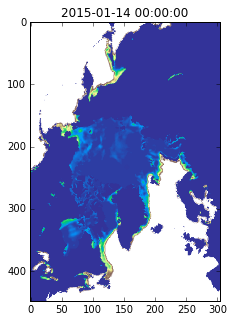

In [12]:
%matplotlib inline

DATES_ARRAY = []

def render(INDEX):
    datetime = get_current_datetime(INDEX)
    image = None
    try:
        with open(form_uri(datetime), 'rb') as fp:
            header = fp.read(300)
            read_data = np.fromfile(fp, dtype=np.uint8).reshape(get_current_dataset_shape())
        image = create_plot(datetime, read_data)
        set_last_dataset(read_data)
        if VERBOSE:
            print("Rendering data for " + str(datetime))
    except FileNotFoundError as e:
        print("----ERROR: No file for " + str(datetime) + "----")
        image = create_plot(datetime, get_last_dataset(), title="FILE MISSING FOR")
    except ValueError as e:
        print("----ERROR: Corrupt file for " + str(datetime) + "----")
        image = create_plot(datetime, get_last_dataset(), title="CORRUPTED FILE FOR")
    else:
        INDEX += 1
        return [image]
    
def setup():
    for date in daterange(TIMEFRAME):
        DATES_ARRAY.append(date)
        
setup()

fig = plt.figure(figsize=(ANIMATION_WIDTH, ANIMATION_HEIGHT))
anim = animation.FuncAnimation(fig, render, frames=len(DATES_ARRAY), fargs=INDEX, interval=INTERVAL, repeat=True)
HTML(anim.to_html5_video())